## Novelty Food Recommendations
**Cleaning Key Features & Indicators**

Progress chart: This explains and identifies what steps I took to acheive my results for this recommendation.

In [89]:
#importing libraries
import pandas as pd #pandas takes care of all file handling
from bokeh.models import BoxAnnotation #bokeh is a plot library and boxannotation will help with aspects of the graph
from bokeh.plotting import figure, show  #help with shape and view aspect of the graph
from bokeh.io import output_notebook #gives it the "in notebook" display rather than an HTML display
from bokeh.models import ColumnDataSource, HoverTool #added tools for better features of the graph

output_notebook()

#Data setup
data = {
    'Week': ['May 1-14', 'May 15-Jun 4', 'Jun 5-19', 'Jun 20-23', 'Jun 24-25'],
    'Task': [
        'Data processing',
        'Key features & indicators',
        'Model training & evaluation',
        'A/b testing, Model refinement',
        'Next Steps'
    ],
    'Start': ['2023-05-01', '2023-05-15', '2023-06-05', '2023-06-20', '2023-06-24'],
    'End': ['2023-05-14', '2023-06-04', '2023-06-19', '2023-06-23', '2023-06-25']
}

df = pd.DataFrame(data)
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

#Column data source creation
source = ColumnDataSource(df)

#colors for each task
colors = ['gray', 'green', 'red', 'purple', 'orange']

#figure creation
p = figure(title="CAPSTONE Schedule", x_axis_type='datetime', y_range=df['Task'], plot_width=800, plot_height=400, tools="")

for indx, task in enumerate(df['Task']):
    task_source = ColumnDataSource(df[df['Task'] == task])
    p.hbar(y='Task', height=0.9, left='Start', right='End', color=colors[indx], source=task_source)

#shading the passive and active intervals
box = BoxAnnotation(left=pd.to_datetime('2023-05-01'), right=pd.to_datetime('2023-05-14'), fill_color='lightgrey', fill_alpha=0.1)
box2 = BoxAnnotation(left=pd.to_datetime('2023-05-15'), right=pd.to_datetime('2023-06-05'), fill_color='lightgreen', fill_alpha=0.1)

#displaying them
p.add_layout(box)
p.add_layout(box2)

#this allows the cursor to hover over it
hover = HoverTool(tooltips=[("Task", "@Task"), ("Start", "@Start{%F}"), ("End", "@End{%F}")], formatters={"@Start": "datetime", "@End": "datetime"})
p.add_tools(hover)

#these are the labels
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Task"
p.ygrid.grid_line_color = None
p.xaxis.major_label_orientation = 1

#shows the graph
show(p)


Loading BokehJS ...

## Table of Contents


<a id="0"></a> <br>
1. [Cleaning the Data](#0.2)

2. [User Interactions](#0.3)

3. [Regex Clean Values](#0.4)

3. [Colinearity](#0.5)


## Cleaning the data:

In this clean I will demonstrate a bit more depth on the dataset acquired.  The knowledge behind what areas I focused on and why.  First I want to credit the overall dataset could have been much dirtier but because this data was pretty organized to begin with there was just some minor areas to wrinkle out but overall moving to modelling was not the initial challenge.  I will show rather than explain.

**Recipe Data**

In [51]:
#reads in the data, and sets the column widths as maximum inorder to be able to see the entire value of each cell
pd.set_option('display.max_colwidth', None)
#reading in the recipe dataset with pandas as pd
Raw_recipes = pd.read_csv('Capstone/RAW_recipes.csv')

In [ ]:
#reading in the recipe dataset with pandas as pd
Raw_ints = pd.read_csv('Capstone/RAW_interactions.csv')

Task at hand:  Implicit features are far more valuable than explicit features. 

In our case thats nutrition & ingredients.  We can not leave behind descriptions and tags as columns to clean and correct of all the useless space and special characters that exist in those values.  In addition we need to combine the two tables and make sure there is no data leakage before starting our recommendation function.

Let's quickly review what we have!

In [90]:
#list columns
Raw_recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'time_interval'],
      dtype='object')

In [92]:
#list columns
Raw_ints.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

In [93]:
#number of rows in the dataset and number of columns
Raw_recipes.shape

(231637, 13)

In [94]:
#number of rows in the dataset and number of columns
Raw_ints.shape

(1132367, 5)

Just to iterate here are the columns and shape of each table - its good to note that these are tables as is.  So far there's only been exploration no further cleaning or tampering just yet.

In [96]:
#Drop duplicate rows
df_r = Raw_recipes.drop_duplicates('name')
df_r.shape

(230186, 13)

Dropping the duplicate names from the **'name'** column only reduced our data from 1451 rows.  I'm sure there's Na's - let's drop any Na's as well. 

In [97]:
#Drop Na's in the dataset
df_r = df_r.dropna()
df_r.shape

(212199, 13)

This dropped almost 18k Rows.  

In [99]:
# Create a DataFrame of the rows with at least one missing value
df_na = Raw_recipes[Raw_recipes.isna().any(axis=1)]

# Now you can inspect the rows that will be dropped
print(df_na)

                                     name      id  minutes  contributor_id  \
5                 apple a day  milk shake    5289        0            1533   
8                bananas 4 ice cream  pie   70971      180          102353   
11          better than sex  strawberries   42198     1460           41531   
12        better then bush s  baked beans   67547     2970           85627   
13             boat house  collard greens  107517      525          137696   
...                                   ...     ...      ...             ...   
231534              zucchini garlic pasta   49456       40           37779   
231549  zucchini sausage brunch casserole  181958      540           89831   
231554           zucchini tomato frittata   73629       45           29300   
231573          zuni caf zucchini pickles  316950     2895           62264   
231603            zupse bread swiss bread  115337      290          107135   

         submitted  \
5       1999-12-06   
8       2003-09-10 

Na's are in the 'description' column which isn't too alarming, but when I see it in the 'time interval' column - that makes one indication that even though it appears to have complete values in the tags column; that is not the case.

To avoid further interruptions towards completing our goal lets continue by removing these columns - once the data is cleaned we now should start to add the features we were originally discussing.  Nutrition and ingredients.

In [100]:
#Reset index
df_r2 = df_r.reset_index(drop=True)
#Split the nutrition values in to each column
Nutri_Cols = pd.DataFrame(df_r2['nutrition'].str.strip('[]').str.replace(',', '').str.split().to_list())

Setting up the nutrition table and providing column names for each numeric value - provided the originators.

In [101]:
#Create column names for each nutrition value
Nutri_Cols.columns = ['Calories (#)', 'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat', 'Carbohydrates (PDV)'] 
#Show the nutrition dataset
Nutri_Cols.head(5)


,Calories (#),Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat,Carbohydrates (PDV)
0,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,352.9,1.0,337.0,23.0,3.0,0.0,28.0


Combining the dataset and droping the original nutrition column since that does not provide anymore value.

In [104]:
#dropping the original column nutrition
c = Raw_recipes.drop(columns = ['nutrition'])

#combining the nutrition table back to the main database
b = c.join(Nutri_Cols)

In [112]:
#sanity check to see if the numerical values are read as number types
b.dtypes

name                     object
id                        int64
minutes                   int64
contributor_id            int64
submitted                object
tags                     object
n_steps                   int64
steps                    object
description              object
ingredients              object
n_ingredients             int64
time_interval          category
Calories (#)             object
Total Fat (PDV)          object
Sugar (PDV)              object
Sodium (PDV)             object
Protein (PDV)            object
Saturated Fat            object
Carbohydrates (PDV)      object
dtype: object

In [113]:
# Convert columns to 'int64', invalid parsing will be set as NaN
b['Calories (#)'] = pd.to_numeric(b['Calories (#)'], errors='coerce').astype('float64')
b['Total Fat (PDV)'] = pd.to_numeric(b['Total Fat (PDV)'], errors='coerce').astype('float64')
b['Sugar (PDV)'] = pd.to_numeric(b['Sugar (PDV)'], errors='coerce').astype('float64')
b['Sodium (PDV)'] = pd.to_numeric(b['Sodium (PDV)'], errors='coerce').astype('float64')
b['Protein (PDV)'] = pd.to_numeric(b['Protein (PDV)'], errors='coerce').astype('float64')
b['Saturated Fat'] = pd.to_numeric(b['Saturated Fat'], errors='coerce').astype('float64')


In [118]:
#2nd sanity check
b.dtypes

name                     object
id                        int64
minutes                   int64
contributor_id            int64
submitted                object
tags                     object
n_steps                   int64
steps                    object
description              object
ingredients              object
n_ingredients             int64
time_interval          category
Calories (#)            float64
Total Fat (PDV)         float64
Sugar (PDV)             float64
Sodium (PDV)            float64
Protein (PDV)           float64
Saturated Fat           float64
Carbohydrates (PDV)      object
dtype: object

In [127]:
#Show shape of current dataset
b.shape

(231637, 19)

In [130]:
#counting if na's still exist in the data
na_count = b.isna().sum()
print(na_count)

#let's drop the time interval column as this may not reflect the na's in the our feature extractions with nutrition column
g = b.drop(columns = ['time_interval'])

name                       1
id                         0
minutes                    0
contributor_id             0
submitted                  0
tags                       0
n_steps                    0
steps                      0
description             4979
ingredients                0
n_ingredients              0
time_interval          14063
Calories (#)           19438
Total Fat (PDV)        19438
Sugar (PDV)            19438
Sodium (PDV)           19438
Protein (PDV)          19438
Saturated Fat          19438
Carbohydrates (PDV)    19438
dtype: int64


**Nutrition EDA - viewing the nutrition by Calorie, Total Fat, Sugar and Protein**

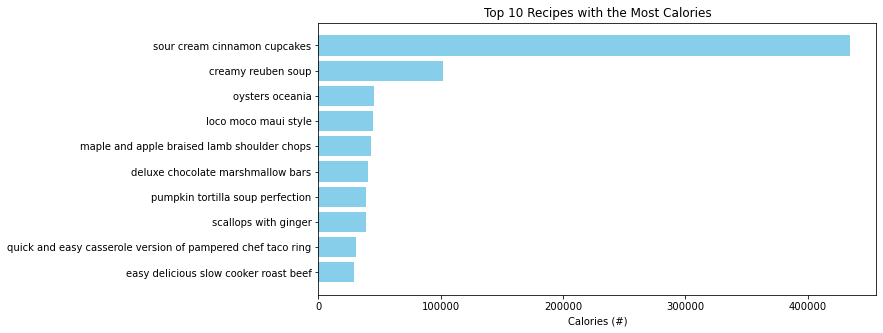

In [136]:
# Sort the DataFrame by 'Calories (#)' in descending order and select top 10
top_calories = b.sort_values('Calories (#)', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(top_calories['name'], top_calories['Calories (#)'], color='skyblue')
plt.xlabel('Calories (#)')
plt.title('Top 10 Recipes with the Most Calories')
plt.gca().invert_yaxis()  # to have the recipe with the most calories on top
plt.show()


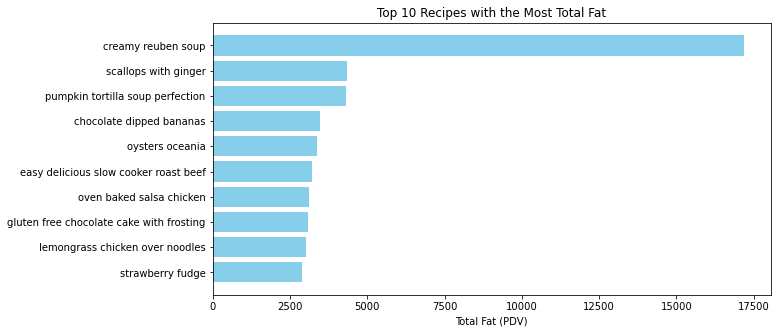

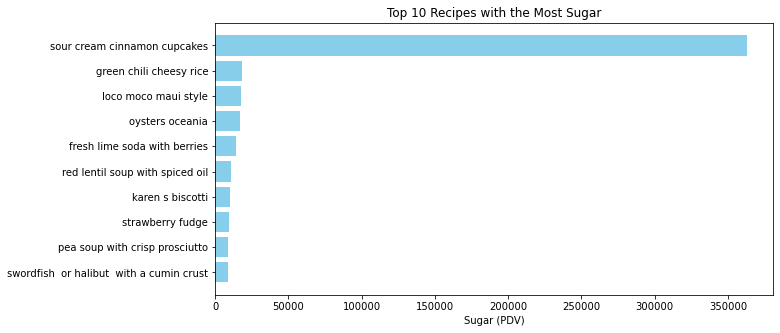

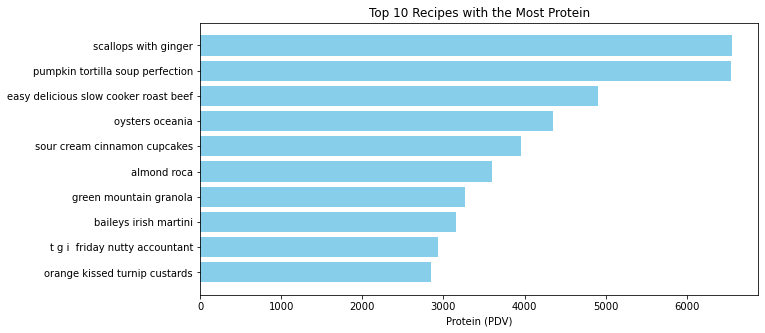

In [132]:
# Sort the DataFrame by 'Total Fat (PDV)' in descending order and select top 10
top_fat = b[b['Total Fat (PDV)'] > 0].sort_values('Total Fat (PDV)', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(top_fat['name'], top_fat['Total Fat (PDV)'], color='skyblue')
plt.xlabel('Total Fat (PDV)')
plt.title('Top 10 Recipes with the Most Total Fat')
plt.gca().invert_yaxis()
plt.show()

# Sort the DataFrame by 'Sugar (PDV)' in descending order and select top 10
top_sugar = b[b['Sugar (PDV)'] > 0].sort_values('Sugar (PDV)', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(top_sugar['name'], top_sugar['Sugar (PDV)'], color='skyblue')
plt.xlabel('Sugar (PDV)')
plt.title('Top 10 Recipes with the Most Sugar')
plt.gca().invert_yaxis()
plt.show()

# Sort the DataFrame by 'Protein (PDV)' in descending order and select top 10
top_protein = b[b['Protein (PDV)'] > 0].sort_values('Protein (PDV)', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(top_protein['name'], top_protein['Protein (PDV)'], color='skyblue')
plt.xlabel('Protein (PDV)')
plt.title('Top 10 Recipes with the Most Protein')
plt.gca().invert_yaxis()
plt.show()


There is a ton of exploration in this space that helps to better recommend recipes that are tailored to each individual users preference.  For the case of more complex solutions we will dive deeper into **next steps** portion.


**Some interesting findings here:**

*Calories* - marinated steaks with tangy butter, rainbow squares, cheesy rolls to have with soup or snack, breakfast sausages, chocolate rice

*Total Fat* - creamy ruben soup, scallops with ginger, pumpkin tortilla soup, chocolate dipped bananas

*Most Sugar* - sour cream cinnamon cupcakes, green chilli cheesy rice, loco moco maui style, oysters oceania.

*Protein* - scallops with ginger, pumpkin tortilla soup perfection, slow cooker roast beef and how cinnamon bun having 40k+ calories. 



**Some surprising finds were** - almond roca having more protein than custards, and pumpkin tortilla soup having more protein than roast beef.

**Extra EDA:** What are the bottom 10 for *Calories, Total Fat, Sugar & Protein?*

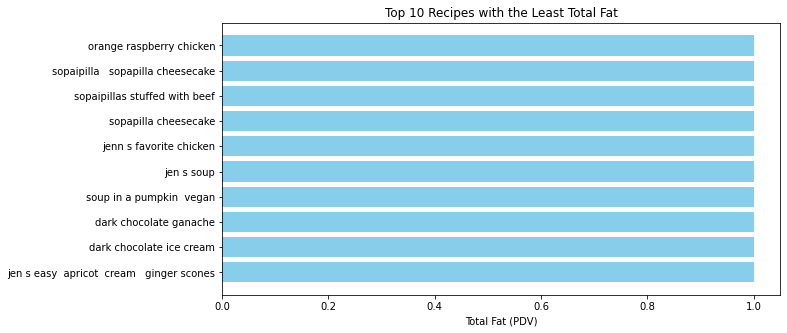

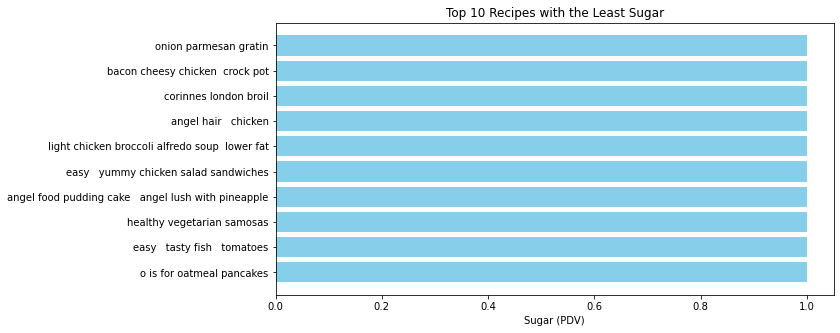

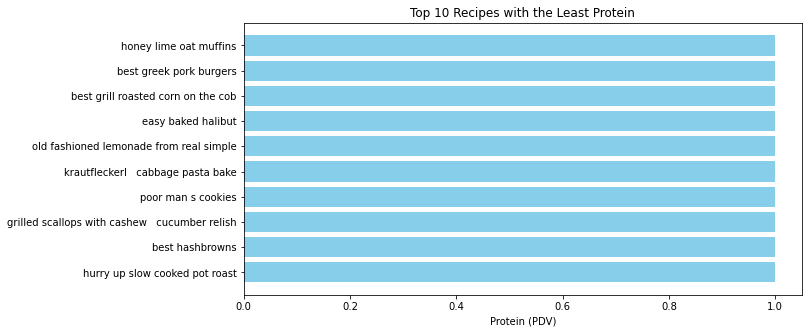

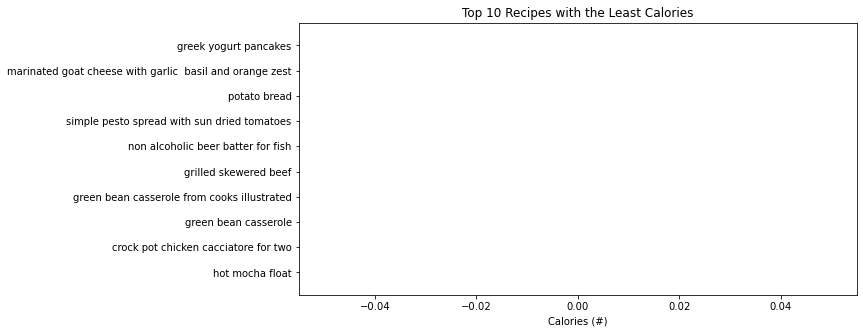

In [133]:
# Sort the DataFrame by 'Total Fat (PDV)' in ascending order and select bottom 10
bottom_fat = b[b['Total Fat (PDV)'] > 0].sort_values('Total Fat (PDV)', ascending=True).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(bottom_fat['name'], bottom_fat['Total Fat (PDV)'], color='skyblue')
plt.xlabel('Total Fat (PDV)')
plt.title('Top 10 Recipes with the Least Total Fat')
plt.gca().invert_yaxis()
plt.show()

# Sort the DataFrame by 'Sugar (PDV)' in ascending order and select bottom 10
bottom_sugar = b[b['Sugar (PDV)'] > 0].sort_values('Sugar (PDV)', ascending=True).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(bottom_sugar['name'], bottom_sugar['Sugar (PDV)'], color='skyblue')
plt.xlabel('Sugar (PDV)')
plt.title('Top 10 Recipes with the Least Sugar')
plt.gca().invert_yaxis()
plt.show()

# Sort the DataFrame by 'Protein (PDV)' in ascending order and select bottom 10
bottom_protein = b[b['Protein (PDV)'] > 0].sort_values('Protein (PDV)', ascending=True).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(bottom_protein['name'], bottom_protein['Protein (PDV)'], color='skyblue')
plt.xlabel('Protein (PDV)')
plt.title('Top 10 Recipes with the Least Protein')
plt.gca().invert_yaxis()
plt.show()

# Sort the DataFrame by 'Calories (#)' in ascending order and select bottom 10
bottom_calories = b.sort_values('Calories (#)', ascending=True).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(bottom_calories['name'], bottom_calories['Calories (#)'], color='skyblue')
plt.xlabel('Calories (#)')
plt.title('Top 10 Recipes with the Least Calories')
plt.gca().invert_yaxis()  
plt.show()


This is why exploration deserves more credit: for example this 'top 10 recipes with the least calories' visual - shows empty values.  *grilled skewered Beef* definitely has calories. 

In [134]:
#using another drop na to drop any missing/nan values
recipe_clean = g.dropna()

In [135]:
#seeing how many dropped and making sure we dropped the correct values
recipe_clean.shape

(207619, 18)

24k were further dropped and this is very possible with the calories chart above showing zero calories towards some recipes when we know are full of calories.

## User Interactions

Before further EDA Let's combine the user interactions dataset.  Let's drop na's and any other issues we see within the data set.

In [120]:
#Raw user interactions data set
Raw_ints.head(5)
Raw_ints.shape

(1132367, 5)

In [121]:
#drop duplicates 
df_int = Raw_ints.drop_duplicates('review')
df_int.shape

(1125283, 5)

70084 are now dropped from using drop duplicates function.

Of all the columns to drop duplicates, reviews would be the first.  We are not looking for auto-generated reviews or the same type of review for a different product that may also not be considered a valuable review.


These decisions are very subjective but these tough calls must be made inorder to move towards a recommendation on only the data we can ensure is quality.  The remaining must be further vetted.

In [122]:
#drop Na's
df_int = df_int.dropna()
df_int.shape

(1125282, 5)

1 was dropped that has Na - this could have been the extra empty row.

In [138]:
df_int2 = df_int.reset_index(drop=True)
df_int2.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!"
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunko. Everyone loved it.
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!"


I want to rename the dataset before completing the merge to avoid any errors.

In [141]:
#Rename Columns
df_int2.columns = ['user', 'id', 'date', 'rate', 'rev']

I'm merging with the dataset - using 'inner' method and combining it on the id.


*Note: in the above cell I changed the recipe id = id for that this extact reason*

In [142]:
#Inner merge the renamed columns with the Recipe Data set on 'Id'
resultdf =recipe_clean.merge(df_int2,how="inner",on="id")

In [143]:
#show the new dataset
resultdf.head(5)

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat,Carbohydrates (PDV),user,date,rate,rev
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas', 'seasonal', 'squash']",11,"['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking', 'if desired , season with salt']","autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or sweet, your choice!\r\ntwo of my posted mexican-inspired seasoning mix recipes are offered as suggestions.","['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']",...,0.0,13.0,0.0,2.0,0.0,4.0,4470,2006-02-18,5,"I used an acorn squash and recipe#137681 Sweet Mexican spice blend. Only used 1 tsp honey & 1 tsp butter between both halves,, sprinkled the squash liberally with the spice mix. Baked covered for 45 minutes uncovered or 15. I basted the squash with the the butter/honey from the cavity allowing it to get a golden color. Lovely Squash recipe Thanks Cookgirl"
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas', 'seasonal', 'squash']",11,"['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking', 'if desired , season with salt']","autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or sweet, your choice!\r\ntwo of my posted mexican-inspired seasoning mix recipes are offered as suggestions.","['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']",...,0.0,13.0,0.0,2.0,0.0,4.0,593927,2010-08-21,5,This was a nice change. I used butternut squash and the sweet option using a good local honey and unsalted butter. I did not add salt. We ate this on top of recipe#322603 with Balkan yogurt. I may make this again same option. Made for Ramadan Tag 2010.
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas', 'seasonal', 'squash']",11,"['mak

In [144]:
#Show shape of new dataset
resultdf.shape

(1003921, 22)

In [145]:
#corrects the new data, seeks for duplicates
bool_series = resultdf.duplicated()

In [146]:
#Sanity check on duplicates
bool_series

0          False
1          False
2          False
3          False
4          False
           ...  
1003916    False
1003917    False
1003918    False
1003919    False
1003920    False
Length: 1003921, dtype: bool

In [147]:
# Applying the method
check_nan = resultdf.isnull().values.any()

In [148]:
check_nan

False

In [149]:
# applying the method
count_nan = resultdf.isnull().sum()
 
# printing the number of values present
# in the column
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: name                   0
id                     0
minutes                0
contributor_id         0
submitted              0
tags                   0
n_steps                0
steps                  0
description            0
ingredients            0
n_ingredients          0
Calories (#)           0
Total Fat (PDV)        0
Sugar (PDV)            0
Sodium (PDV)           0
Protein (PDV)          0
Saturated Fat          0
Carbohydrates (PDV)    0
user                   0
date                   0
rate                   0
rev                    0
dtype: int64


**This validates that the data is clean, no nan's or missing values.**

Missing values really speak to the data integrity.  Given that the original data sets were at 230k in recipes and 1.15 million for user interactions.

## REGEX CLEAN VALUES

*Definition*


Regular Expressions, also known as “regex” or “regexp”, are used to match strings of text such as particular characters, words, or patterns of characters. It means that we can match and extract any string pattern from the text with the help of regular expressions

We will clean the string values that would be required for further use in the recommendation system.
Ingredients is great.
Steps is another great option.
Tags are also amazing to do this with as well.

In [150]:
#Regex to clean the ingredients columns
resultdf['ingredients'] = resultdf['ingredients'].str.replace('[^\w\s]','')  

/var/folders/3h/c9q_p3653g7088wkgdk7bfmm0000gn/T/ipykernel_49538/3664929890.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  resultdf['ingredients'] = resultdf['ingredients'].str.replace('[^\w\s]','')


In [151]:
#Regex to clean the steps columns
resultdf['steps'] = resultdf['steps'].str.replace('[^\w\s]','')  

/var/folders/3h/c9q_p3653g7088wkgdk7bfmm0000gn/T/ipykernel_49538/3993976844.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  resultdf['steps'] = resultdf['steps'].str.replace('[^\w\s]','')


In [152]:
#Regex to clean the tags columns
resultdf['tags'] = resultdf['tags'].str.replace('[^\w\s]','')  

/var/folders/3h/c9q_p3653g7088wkgdk7bfmm0000gn/T/ipykernel_49538/2344264071.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  resultdf['tags'] = resultdf['tags'].str.replace('[^\w\s]','')


In [153]:
#copy the cleaned dataset
df2_clean = resultdf.copy()
df2_clean.shape

(1003921, 22)

In [154]:
#Display the clean data
df2_clean.head(5)

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat,Carbohydrates (PDV),user,date,rate,rev
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,60minutesorless timetomake course mainingredient cuisine preparation occasion northamerican sidedishes vegetables mexican easy fall holidayevent vegetarian winter dietary christmas seasonal squash,11,make a choice and proceed with recipe depending on size of squash cut into half or fourths remove seeds for spicy squash drizzle olive oil or melted butter over each cut squash piece season with mexican seasoning mix ii for sweet squash drizzle melted honey butter grated piloncillo over each cut squash piece season with sweet mexican spice mix bake at 350 degrees again depending on size for 40 minutes up to an hour until a fork can easily pierce the skin be careful not to burn the squash especially if you opt to use sugar or butter if you feel more comfortable cover the squash with aluminum foil the first half hour give or take of baking if desired season with salt,"autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or sweet, your choice!\r\ntwo of my posted mexican-inspired seasoning mix recipes are offered as suggestions.",winter squash mexican seasoning mixed spice honey butter olive oil salt,...,0.0,13.0,0.0,2.0,0.0,4.0,4470,2006-02-18,5,"I used an acorn squash and recipe#137681 Sweet Mexican spice blend. Only used 1 tsp honey & 1 tsp butter between both halves,, sprinkled the squash liberally with the spice mix. Baked covered for 45 minutes uncovered or 15. I basted the squash with the the butter/honey from the cavity allowing it to get a golden color. Lovely Squash recipe Thanks Cookgirl"
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,60minutesorless timetomake course mainingredient cuisine preparation occasion northamerican sidedishes vegetables mexican easy fall holidayevent vegetarian winter dietary christmas seasonal squash,11,make a choice and proceed with recipe depending on size of squash cut into half or fourths remove seeds for spicy squash drizzle olive oil or melted butter over each cut squash piece season with mexican seasoning mix ii for sweet squash drizzle melted honey butter grated piloncillo over each cut squash piece season with sweet mexican spice mix bake at 350 degrees again depending on size for 40 minutes up to an hour until a fork can easily pierce the skin be careful not to burn the squash especially if you opt to use sugar or butter if you feel more comfortable cover the squash with aluminum foil the first half hour give or take of baking if desired season with salt,"autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or sweet, your choice!\r\ntwo of my posted mexican-inspired seasoning mix recipes are offered as suggestions.",winter squash mexican seasoning mixed spice honey butter olive oil salt,...,0.0,13.0,0.0,2.0,0.0,4.0,593927,2010-08-21,5,This was a nice change. I used butternut squash and the sweet option using a good local honey and unsalted butter. I did not add salt. We ate this on top of recipe#322603 with Balkan yogurt. I may make this again same option. Made for Ramadan Tag 2010.
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,60minutesorless timetomake course mainingredient cuisine preparation occasion northamerican sidedishes vegetables mexican easy fall holidayevent vegetarian winter dietary christmas seasonal squash,11,make a choice and proceed with recipe depending on size of squash cut into half or fourths remove seeds for spicy squash drizzle olive oil or melted butter over each cut squash piece season with mexican seasoning mix ii for sweet squash drizzle melted honey butter grated piloncillo over each cut squash piece season with sweet mexican spice mix bake at 350 degrees again depending on size 

Now the final dataset sits at 1 million rows, combining user review and recipe details in 1 table.

In [155]:
#Add user counts another feature
df2_usercount = df2_clean.groupby(['user']).count().reset_index()

In [156]:
#Show user counts
df2_usercount.head(5)

,user,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,...,Calories (#),Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat,Carbohydrates (PDV),date,rate,rev
0,1533,110,110,110,110,110,110,110,110,110,...,110,110,110,110,110,110,110,110,110,110
1,1535,706,706,706,706,706,706,706,706,706,...,706,706,706,706,706,706,706,706,706,706
2,1581,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1634,53,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53
4,1676,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


We only need one column and then combine it back to the original dataframe before we can sample and begin the modeling.

In [158]:
#Drop all columns but 1
#Change count name
#Add the count column to the main dataset
df2_usercounta = df2_usercount[['user','name']]
df2_usercounta.columns = ['user', 'count']
df2_usercounta.sort_values('count')
resultdf2 =df2_usercounta.merge(df2_clean,how="inner",on="user")


In [159]:
#View new dataset
resultdf2
resultdf2.shape

(1003921, 23)

In [161]:
#View new data values
resultdf2.head(5)

,user,count,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,...,Calories (#),Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat,Carbohydrates (PDV),date,rate,rev
0,1533,110,apricot mousse,68986,25,60989,2003-08-13,30minutesorless timetomake course mainingredient preparation for1or2 5ingredientsorless gelatin desserts fruit easy beginnercook puddingsandmousses dietary numberofservings presentation servedcold,9,put apricots in bowl and cover with boiling water set aside for 1 hour to soften place drained apricots in blender add honey and blend until smooth in a small saucepan dissolve gelatin in 2 tbls of water place on low heat and stir until all gelatin is dissolved combine cottage cheese and yogurt in a seperate bowl and whip until smooth pour yogurt mixture into a bowl and slowly stir in the gelatin the fold in the apricot puree refrigerate for 1 hour before serving enjoy,...,1009.4,64.0,32.0,105.0,76.0,33.0,47.0,2003-09-28,5,I made this tonight and oh my it turned out very nice. it was smooth (i used the blender) very tasty and everyone enjoyed it.\r\nThanks Bekah. Its a keeper.
1,1533,110,bacon and cheese egg appetizers,31048,27,23302,2002-06-12,bacon 30minutesorless timetomake course mainingredient cuisine preparation occasion northamerican appetizers breakfast lunch eggsdairy pork american canadian southernunitedstates easy european dinnerparty fingerfood holidayevent kidfriendly picnic english cheese eggs stovetop dietary christmas newyears thanksgiving glutenfree californian pacificnorthwest independenceday northeasternunitedstates freeofsomething meat togo equipment presentation,4,using a knife cut the outside of the egg white just as far as the yolk and carefully remove the egg white leaving the yolks intact mash the egg yolks and stir with the mayonnaise bacon vinegar cheese and salt fill the egg white halves with the mixture top with the crumbled bacon,...,472.1,43.0,146.0,3.0,13.0,44.0,17.0,2002-07-28,5,"A tray of these barely made it to the table.\r\nI never new so many people liked stuffed eggs.\r\nI never changed a thing, just tripled the recipe. Very good recipe its a keeper."
2,1533,110,barley potato soup,48475,80,38532,2002-12-12,weeknight timetomake course mainingredient preparation soupsstews vegetables dietary pastariceandgrains 4hoursorless,6,bring the broth to a boil and add the barley stir then let simmer for 30 minutes covered meanwhile heat the olive oil and butter in a saute pan over medium heat add the onion celery garlic parsley red pepper flakes and the remaining herbs and saute until the vegetables are softened but not browned when the barley has cooked for 30 minutes add this mixture to it along with the carrots and potatoes cook everything together at a simmer for another 30 minutes serve with a generous sprinkle of parmesan on top,...,520.0,12.0,6.0,64.0,54.0,13.0,28.0,2003-09-23,4,"This soup was very good, I do agree it needs a little more barley and broth. I will make it again, Thanks"
3,1533,110,basic beer batter,114839,1450,195447,2005-03-31,timetomake course preparation condimentsetc 1dayormore dietary lowsodium cookingmixes lowinsomething,4,combine all dry ingredients add liquid ingredients and mix well allow batter to chill in refrigerator for a least 1 hour before using dip food in batter and place into hot oil,...,238.0,17.0,57.0,9.0,13.0,11.0,9.0,2005-04-18,5,"I used this on halibut last night, I make homemade fish and chips.\r\nThe taste was great the beer was not overpowering. thanks so much for posting. Its a keeper."
4,1533,110,basil garlic butter,32311,15,35193,2002-06-26,15minutesorless timetomake course cuisine preparation occasion northamerican lowprotein 5ingredientsorless verylowcarbs condimentsetc american easy nocook refrigerator dinnerparty spring summer vegetarian freezer dietary lowsodium seasonal pacificnorthwest lowcarb inexpensive lowinsomething equipment numberofservings technique,6,place the butter in a mixing bowl add basil garlic a

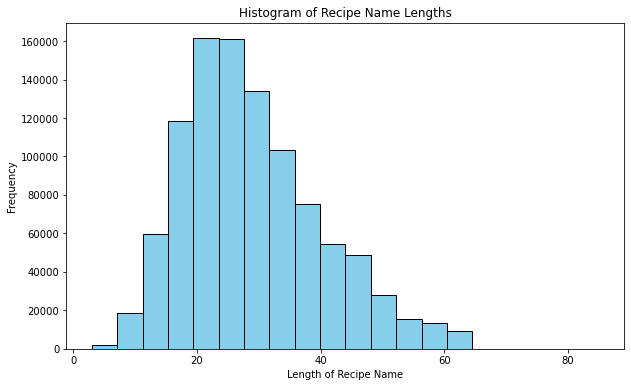

In [164]:
# Create a new column for the length of the recipe name
resultdf2['recipe_name_length'] = resultdf2['name'].str.len()

# Plot a histogram of recipe name lengths
plt.figure(figsize=(10,6))
plt.hist(resultdf2['recipe_name_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Recipe Name Lengths')
plt.xlabel('Length of Recipe Name')
plt.ylabel('Frequency')
plt.show()



A few reasons why I wanted to show the distribution for name.

1. I wanted to collect all the information about each set, combine it and then provide more basic EDA on the actual set.
2. first model relies heavely on the name column



The purpose of visualizing the distribution of name lengths in a dataset of recipes may not have immediate apparent value for recipe analysis. However, it can still serve a few potential purposes depending on what the analysis aims to achieve:

**Text Analysis:** If you're doing a text analysis, knowing the length of the names could be useful. For instance, shorter names might be easier to remember or more attractive to users. If there's a noticeable difference in popularity or ratings between recipes with short names and those with long names, that could be an interesting finding.

**Feature Engineering:** The length of the name could potentially be used as a feature in a machine learning model. It's not necessarily the case that it would be a useful feature, but visualizing the distribution of lengths could be a part of the exploratory data analysis process to understand more about the dataset.

In [176]:
print(resultdf2['Calories (#)'].unique())
resultdf2['Calories (#)'].dtype


[1009.4  472.1  520.  ... 2652.  2744.6 3337.2]


dtype('float64')

In [177]:
#making sure the calories column is numeric
resultdf2['Calories (#)'] = pd.to_numeric(resultdf2['Calories (#)'], errors='coerce')


In [200]:
#making sure each nutritional column is correct
print(resultdf2['Sugar (PDV)'].unique())
print(resultdf2['Sodium (PDV)'].unique())
print(resultdf2['Protein (PDV)'].unique())
print(resultdf2['Saturated Fat'].unique())
print(resultdf2['Carbohydrates (PDV)'].unique())



[3.200e+01 1.460e+02 6.000e+00 ... 1.965e+03 8.360e+03 1.105e+03]
[1.0500e+02 3.0000e+00 6.4000e+01 9.0000e+00 1.0000e+01 1.5000e+01
 1.4200e+02 1.7000e+01 0.0000e+00 2.7000e+01 2.0000e+00 7.0000e+00
 6.0000e+00 1.9000e+01 4.0000e+00 2.2000e+01 1.2000e+01 3.5000e+01
 3.1000e+01 4.0000e+01 5.4000e+01 2.1000e+01 3.7000e+01 1.0000e+00
 7.3000e+01 6.0000e+01 7.1000e+01 2.5000e+01 1.1700e+02 4.1000e+01
 4.3000e+01 4.4000e+01 8.0000e+00 1.1000e+01 5.0000e+00 1.4000e+01
 6.2000e+01 8.1000e+01 2.4000e+01 5.1000e+01 9.0000e+01 1.6000e+01
 8.6000e+01 6.3000e+01 4.5000e+01 8.3000e+01 5.6000e+01 2.6000e+01
 2.9000e+01 8.8000e+01 7.2000e+01 1.3000e+01 3.6000e+01 4.9000e+01
 8.0000e+01 3.8000e+01 2.8000e+01 9.9000e+01 3.0000e+01 1.5200e+02
 1.2700e+02 8.5000e+01 4.8000e+01 6.7000e+01 1.8000e+01 1.0100e+02
 5.3000e+01 1.2300e+02 7.9000e+01 7.0000e+01 6.1000e+01 7.7000e+01
 3.3000e+01 8.7000e+01 2.9700e+02 3.2000e+01 1.0300e+02 9.7000e+01
 1.1600e+02 3.4000e+01 5.5000e+01 2.0000e+01 6.6000e+01 4.2000e

In [201]:
#making sure each nutritional column is numeric

resultdf2['Sugar (PDV)'] = pd.to_numeric(resultdf2['Sugar (PDV)'], errors='coerce')
resultdf2['Sodium (PDV)'] = pd.to_numeric(resultdf2['Sodium (PDV)'], errors='coerce')
resultdf2['Protein (PDV)'] = pd.to_numeric(resultdf2['Protein (PDV)'], errors='coerce')
resultdf2['Saturated Fat'] = pd.to_numeric(resultdf2['Saturated Fat'], errors='coerce')
resultdf2['Carbohydrates (PDV)'] = pd.to_numeric(resultdf2['Carbohydrates (PDV)'], errors='coerce')


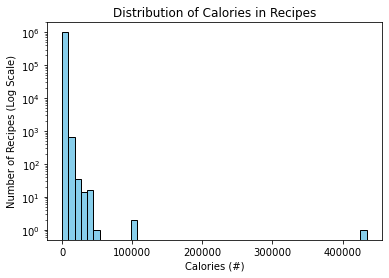

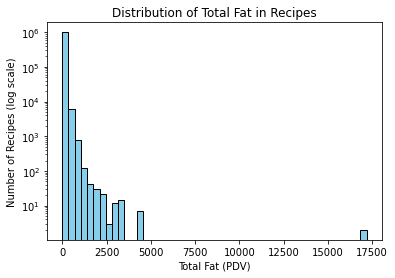

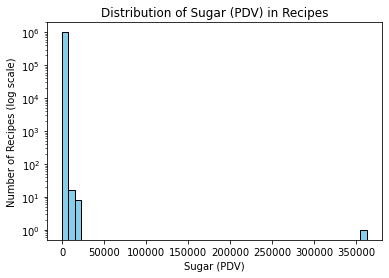

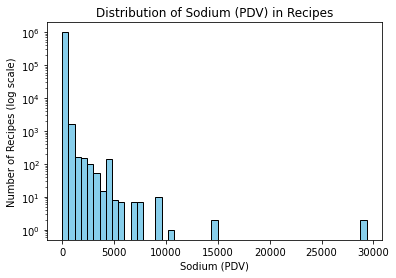

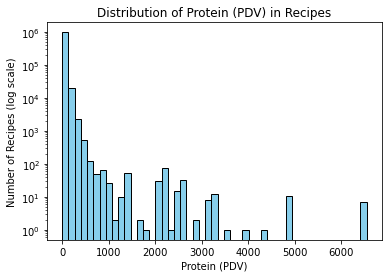

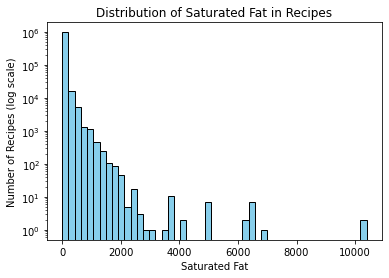

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U3'), dtype('float64')) -> None

In [207]:
# Set the number of bins to be 50 for a detailed, yet manageable, level of granularity
num_bins = 50

# Get the minimum and maximum values in the 'Calories (#)' column
min_val = resultdf2['Calories (#)'].min()
max_val = resultdf2['Calories (#)'].max()

# Create evenly spaced bins from the minimum to maximum value
bins = np.linspace(min_val, max_val, num_bins)

# Create a histogram with the defined bins
plt.hist(resultdf2['Calories (#)'], bins=bins, log=True, color='skyblue', edgecolor='black')

# Label the axes and give the plot a title
plt.xlabel('Calories (#)')
plt.ylabel('Number of Recipes (Log Scale)')
plt.title('Distribution of Calories in Recipes')

# Show the plot
plt.show()

# Set the number of bins to be 50
num_bins = 50

# Get the minimum and maximum values in the 'Total Fat (PDV)' column
min_val = resultdf2['Total Fat (PDV)'].min()
max_val = resultdf2['Total Fat (PDV)'].max()

# Create evenly spaced bins from the minimum to maximum value
bins = np.linspace(min_val, max_val, num_bins)

# Create a histogram with the defined bins
plt.hist(resultdf2['Total Fat (PDV)'], bins=bins, color='skyblue', edgecolor='black', log=True)

# Label the axes and give the plot a title
plt.xlabel('Total Fat (PDV)')
plt.ylabel('Number of Recipes (log scale)')
plt.title('Distribution of Total Fat in Recipes')

# Show the plot
plt.show()

# List of the remaining nutritional columns
nutri_cols = ['Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat', 'Carbohydrates (PDV)']

# For each nutritional column
for col in nutri_cols:
    
    # Set the number of bins to be 50
    num_bins = 50
    
    # Create evenly spaced bins from the minimum to maximum value of the column
    bins = np.linspace(b[col].min(), b[col].max(), num_bins)
    
    # Create a histogram with the defined bins and log scale
    plt.hist(resultdf2[col], bins=bins, color='skyblue', edgecolor='black', log=True)

    # Label the axes and give the plot a title
    plt.xlabel(col)
    plt.ylabel('Number of Recipes (log scale)')
    plt.title('Distribution of ' + col + ' in Recipes')
    
    # Show the plot
    plt.show()



**Calories:** The majority of the recipes have relatively low calorie counts, with only a few recipes being very high in calories. This results in a right-skewed distribution, where the mean is greater than the median.

**Total Fat:** Similar to calories, most recipes have low fat content, while a few are very high in fat. This right-skewness indicates that while most recipes are low-fat, there are some with extremely high fat content that pull the average up.

**Sugar:** The distribution of sugar content in recipes appears to be highly skewed to the right as well. This means that while a majority of the recipes have lower sugar content, there are a few recipes with exceptionally high sugar content.

**Sodium:** The sodium content in the recipes also follows a similar distribution, with the majority of the recipes having low sodium content, and a very small number of recipes having very high sodium content.

**Protein:** The protein content in the recipes follows a similar pattern, with most of the recipes being low in protein and a few recipes containing a large amount of protein.

**Saturated Fat:** The majority of the recipes have a low saturated fat content, with a few outliers having a high content. This results in a right-skewed distribution.

**Carbohydrates:** The carbohydrate content in the recipes shows a right-skewed distribution as well, with most recipes having a lower carbohydrate content, and a few recipes with a very high carbohydrate content.

In general, all the nutritional content columns - Calories, Total Fat, Sugar, Sodium, Protein, Saturated Fat, and Carbohydrates - show a similar pattern. They are all right-skewed, meaning that the majority of the recipes are relatively healthy with low content of these nutritional aspects. However, there are some recipes with exceptionally high content of these nutritional aspects, which might be indulgent or meant for special occasions.

## Colinearity
            Visualizing colinearity with a heatmap with indicators

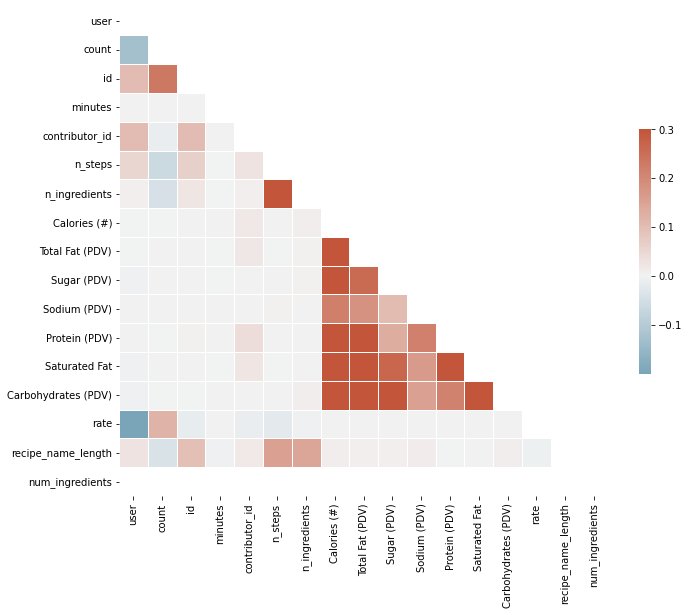

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = resultdf2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


Nutritional facts vs themselves and number of steps vs ingredients is obvious, some interesting finds are id vs count.  Count is valuable in our cosine similarity models.  Because it requires multiple similar features inorder to make a prediction count can be leveraged.

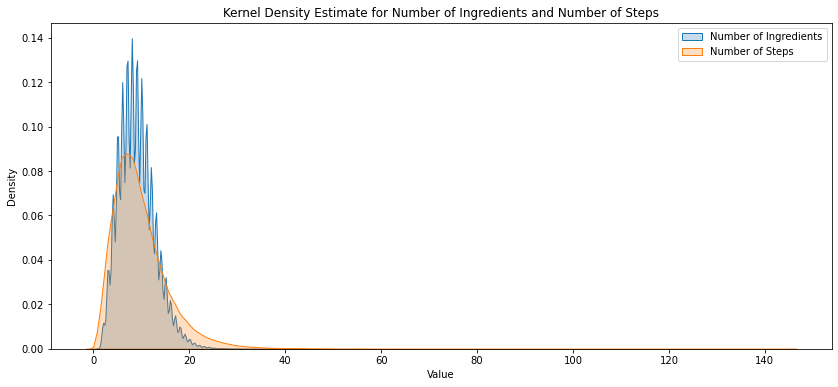

In [222]:
plt.figure(figsize=(14, 6))

# KDE for n_ingredients
sns.kdeplot(b['n_ingredients'], label='Number of Ingredients', shade=True)

# KDE for n_steps
sns.kdeplot(b['n_steps'], label='Number of Steps', shade=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimate for Number of Ingredients and Number of Steps')

plt.legend()
plt.show()



**Kernel Density Estimate (KDE) plot**


The KDE for n_ingredients gives a visual representation of the distribution of the number of ingredients in all the recipes. The peak of this curve represents the mode i.e., the most common number of ingredients that recipes have.

Similarly, the KDE for n_steps represents the distribution of the number of steps in all the recipes. The peak of this curve represents the mode i.e., the most common number of steps that recipes have.

By comparing these two KDEs, we can infer about the commonality of complexity in the recipes. For example, the peak (mode) of n_ingredients is higher than n_steps, it might suggest that most recipes have more ingredients than steps, indicating that the recipes might require more ingredients even with fewer steps.

